## Data Explanation ##

**Stores**
* Store: The store number. Range from 1-45.
* Type: Three types of stores ‘A’, ‘B’ or ‘C’.
* Size: Sets the size of a Store would be calculated by the no. of products available in the particular store ranging from 34,000 to 210,000.

**Features**
* Store: The store which observation in recorded 1-45.
* Date: The date of the week where this observation was taken. 
* Temperature: Temperature of the region during that week.
* Fuel_Price: Fuel Price in that region during that week.
* MarkDown1:5 : Represents the Type of markdown and what quantity was available during that week.
* CPI: Consumer Price Index during that week.
* Unemployment: The unemployment rate during that week in the region of the store.
* IsHoliday: Boolean value representing a holiday week or not.

**Sales**
* Store: The store which observation in recorded 1-45.
* Dept: One of 1-99 that shows the department.
* Date: The date of the week where this observation was taken. 
* Weekly_Sales: The sales recorded during that Week.
* IsHoliday: Boolean value representing a holiday week or not.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from prettytable import PrettyTable
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from scipy.stats import skew

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

%matplotlib inline

stores = pd.read_csv('../input/stores data-set.csv')
features = pd.read_csv('../input/Features data set.csv')
sales = pd.read_csv('../input/sales data-set.csv')

pt = PrettyTable(['data', 'dimension'])
pt.add_row(['stores', stores.shape])
pt.add_row(['features', features.shape])
pt.add_row(['sales', sales.shape])

print(pt, '\n')


Features data set.csv
sales data-set.csv
stores data-set.csv

+----------+-------------+
|   data   |  dimension  |
+----------+-------------+
|  stores  |   (45, 3)   |
| features |  (8190, 12) |
|  sales   | (421570, 5) |
+----------+-------------+ 



In [2]:
#Denormalize data for easy processing
denorm = pd.merge(sales, features, how = 'left', on=['Store', 'Date', 'IsHoliday'])
denorm = pd.merge(denorm, stores, how = 'left', on=['Store'])

denorm['IsReturn'] = ((denorm['Weekly_Sales'] < 0))
denorm = denorm.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis = 1)

denorm['Date'] = pd.to_datetime(denorm['Date'], format="%d/%m/%Y")
#Sales Only
#denormSales = denorm.loc[denorm['IsReturn'] == 0]
denormSales = denorm.copy()
denormSales = denormSales.assign(IsHolidayInt = [int(x) for x in list(denormSales.IsHoliday)])

print(denormSales.columns.tolist())

['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size', 'IsReturn', 'IsHolidayInt']


In [3]:
denormSales.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
CPI,421570.0,171.201947,39.159276,126.064,132.022667,182.31878,212.416993,227.232807
Unemployment,421570.0,7.960289,1.863296,3.879,6.891000,7.86600,8.572000,14.313000
Size,421570.0,136727.915739,60980.583328,34875.000,93638.000000,140167.00000,202505.000000,219622.000000
IsHolidayInt,421570.0,0.070358,0.255750,0.000,0.000000,0.00000,0.000000,1.000000


In [4]:
#causes kernel to fail 
#scatterplot
#sns.set()
#cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Size', 'IsHoliday', 'Type', 'Dept']
#sns.pairplot(denormSales[cols], size = 5)
#plt.show()


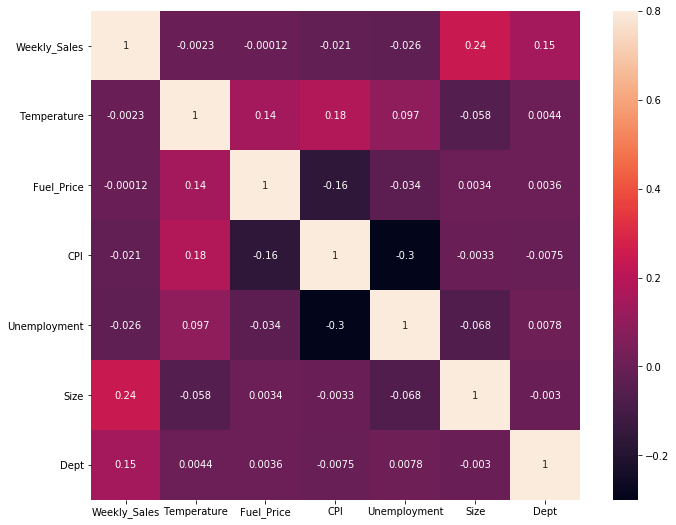

In [5]:
corrmat = denormSales[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size', 'Dept']].corr()

#print(corrmat)

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);
#print(denorm)

In [6]:
denormSales = denormSales.assign(year = denormSales.Date.dt.year)
denormSales = denormSales.assign(week = denormSales.Date.dt.week)
denormSales = denormSales.assign(yearweek = denormSales.year * 100 + denormSales.week)
denormSales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,IsReturn,IsHolidayInt,year,week,yearweek
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,False,0,2010,5,201005
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,False,1,2010,6,201006
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315,False,0,2010,7,201007
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315,False,0,2010,8,201008
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315,False,0,2010,9,201009


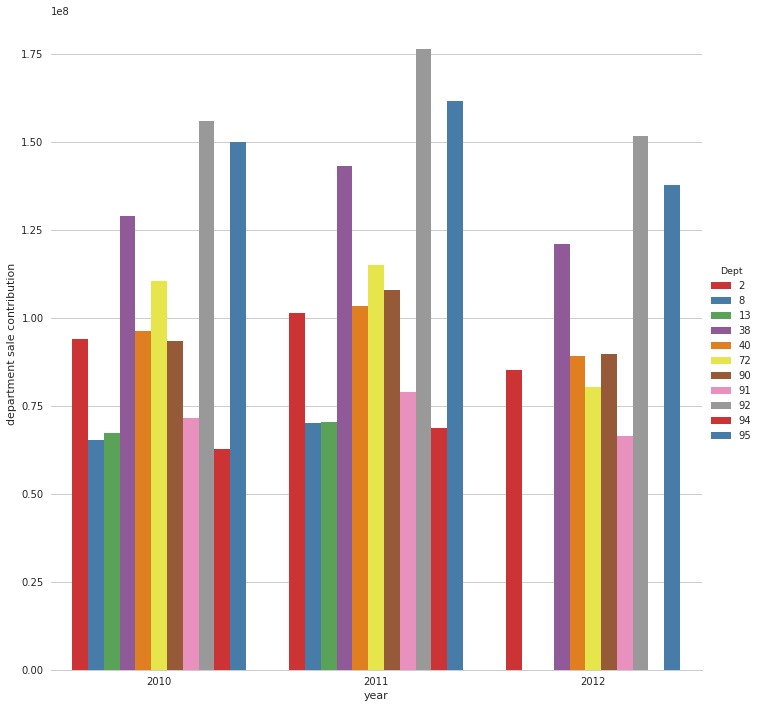

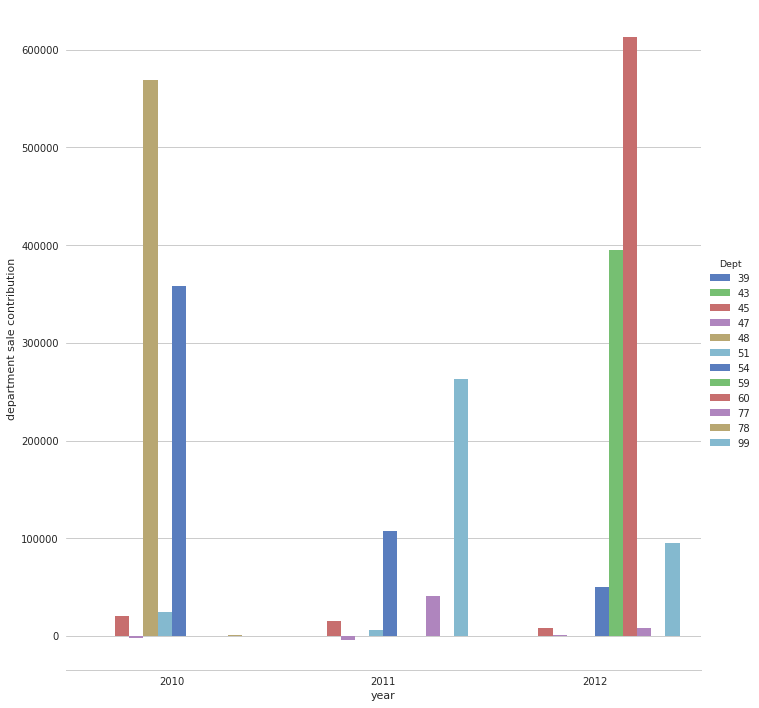

In [7]:
dept_sales = denormSales.groupby(by=(['Dept', 'year']), as_index=False)['Weekly_Sales'].sum()
top_depts = dept_sales.nlargest(30, 'Weekly_Sales')
sns.set(style="whitegrid")
g = sns.factorplot(x="year", y="Weekly_Sales", hue="Dept", data=top_depts,
                   size=10, kind="bar", palette="Set1")
g.despine(left=True)
g.set_ylabels("department sale contribution")



bottom_depts = dept_sales.nsmallest(30, 'Weekly_Sales')
sns.set(style="whitegrid")
g = sns.factorplot(x="year", y="Weekly_Sales", hue="Dept", data=bottom_depts,
                   size=10, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("department sale contribution")

Coefficients: 
 [ -9.08863111e+01   1.08346205e+02   1.48258168e+01  -7.80356148e+01
  -2.10052743e+01  -1.10786134e+02   1.32255758e+03   8.81126991e-02]
Mean squared error: 444775379.20
Variance score: 0.09


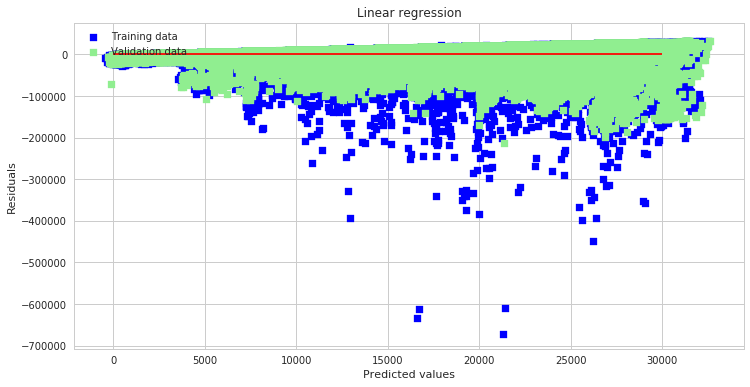

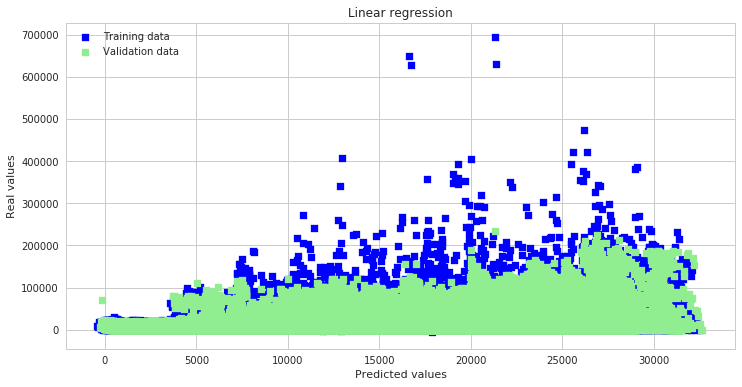

In [8]:
train1 = denormSales.loc[denormSales['year'] != 2012]
test1 = denormSales.loc[denormSales['year'] == 2012]

featureset1 = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHolidayInt', 'Size']

x_train1 = train1[featureset1]
y_train1 = train1['Weekly_Sales']

x_test1 = test1[featureset1]
y_test1 = test1['Weekly_Sales']

lr = LinearRegression()
lr.fit(x_train1, y_train1)

y_pred1 = lr.predict(x_test1)
y_train_pred1 = lr.predict(x_train1)

# The coefficients
print('Coefficients: \n', lr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test1, y_pred1))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test1, y_pred1))

# Plot residuals
plt.figure(figsize=(12,6))
plt.scatter(y_train_pred1, y_train_pred1 - y_train1, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred1, y_pred1 - y_test1, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 0, xmax = 30000, color = "red")
plt.show()

# Plot predictions
plt.figure(figsize=(12,6))
plt.scatter(y_train_pred1, y_train1, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred1, y_test1, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.show()

ExtraTreeRegressor Score: 0.89227072332
Mean squared error: 52713507.09


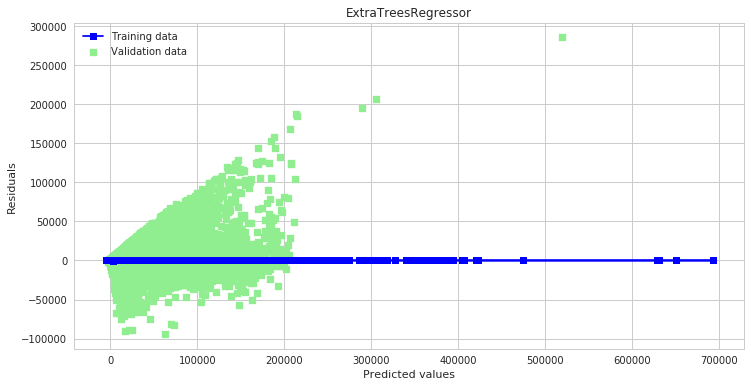

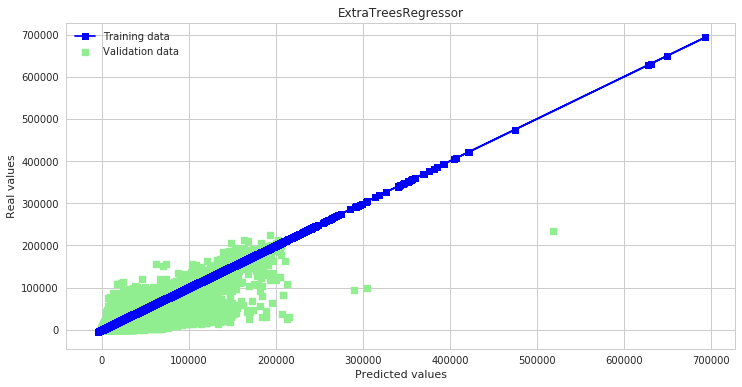

In [9]:
train2 = denormSales.loc[denormSales['year'] != 2012]
test2 = denormSales.loc[denormSales['year'] == 2012]

featureset2 = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHolidayInt', 'Size']

x_train2 = train2[featureset2]
y_train2 = train2['Weekly_Sales']

x_test2 = test2[featureset2]
y_test2 = test2['Weekly_Sales']

etr = ExtraTreesRegressor(n_estimators=200)
etr.fit(x_train2, y_train2)
y_pred2 = etr.predict(x_test2)

y_train_pred2 = etr.predict(x_train2)

print("ExtraTreeRegressor Score:", etr.score(x_test2, y_test2))
print("Mean squared error: %.2f" %
       np.mean((y_test2 - y_pred2) ** 2))

# Plot residuals
plt.figure(figsize=(12,6))
plt.plot(y_train_pred2, y_train_pred2 - y_train2, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred2, y_pred2 - y_test2, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("ExtraTreesRegressor")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.show()

# Plot predictions
plt.figure(figsize=(12,6))
plt.plot(y_train_pred2, y_train2, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_pred2, y_test2, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("ExtraTreesRegressor")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.show()